In [1]:
from pathlib import Path
from datetime import datetime

from codar_processing.src.radials import Radial
from codar_processing.src.calc import gridded_index
from codar_processing.plotting.plot_nc import plot_radials as ncradialsplot
from codar_processing.plotting.plot_nc import plot_common

import rads2uv

In [2]:
# Load (2) overlapping radial files into Radial objects
core_ruv = Path('data/radials/CORE/ideal/2018/201801/20180101/RDL_i_UNC_CORE_2018_01_01_0000.hfrss10lluv')
core_radial = Radial(core_ruv)
core_radial.mask_over_land()
core_xr = core_radial.to_xarray(enhance=True)

duck_ruv = Path('data/radials/DUCK/ideal/2018/201801/20180101/RDL_i_UNC_DUCK_2018_01_01_0000.hfrss10lluv')
duck_radial = Radial(duck_ruv)
duck_radial.mask_over_land()
duck_xr = duck_radial.to_xarray(enhance=True)

<Figure size 432x288 with 0 Axes>

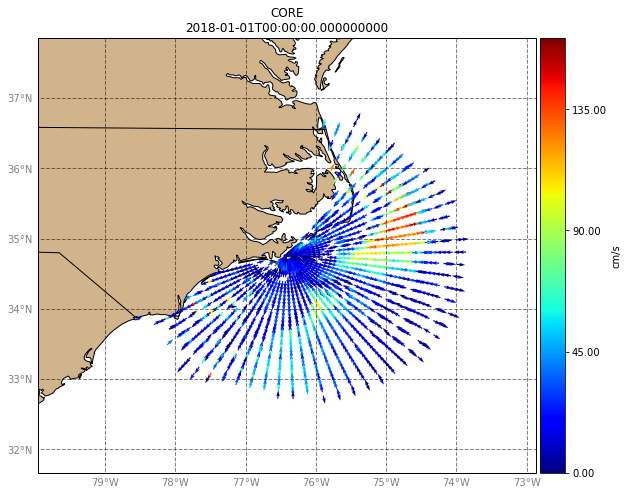

<Figure size 864x612 with 0 Axes>

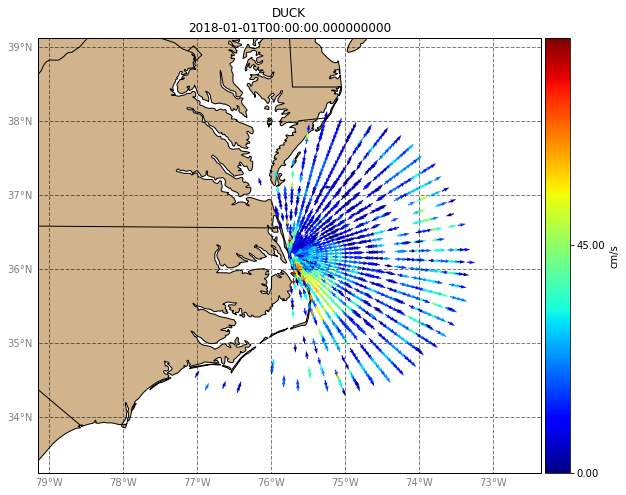

In [3]:
velocity_min = 0
velocity_max = 180
sub = 1

# Plot it directly from an xarray object
ncradialsplot(
    core_xr,
    velocity_min=velocity_min,
    velocity_max=velocity_max,
    sub=sub,
    title='CORE'
)
# Plot it directly from an xarray object
ncradialsplot(
    duck_xr,
    velocity_min=velocity_min,
    velocity_max=velocity_max,
    sub=sub,
    title='DUCK'
)

# Create a standard grid to output

<module 'matplotlib.pyplot' from '/data/conda/miniconda3-py37/envs/dc2020/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 864x612 with 0 Axes>

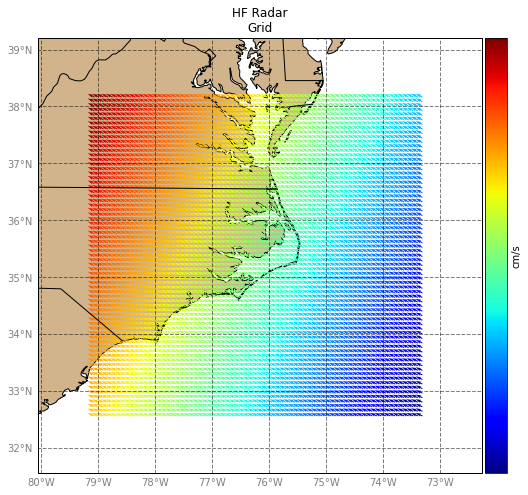

In [4]:
# Create a standard output grid that we will interpolate onto
import numpy as np
import xarray as xr

bottom_left_lat = min(core_xr.lat.data.min(), duck_xr.lat.data.min()) - 0.1
bottom_left_lon = min(core_xr.lon.data.min(), duck_xr.lon.data.min()) - 0.1

top_right_lat = max(core_xr.lat.data.max(), duck_xr.lat.data.max()) + 0.1
top_right_lon = max(core_xr.lon.data.max(), duck_xr.lon.data.max()) + 0.1

# Define grid spacing
spacing = 0.04
lat = np.arange(bottom_left_lat, top_right_lat, spacing)
lon = np.arange(bottom_left_lon, top_right_lon, spacing)
xx, yy = np.meshgrid(lon, lat)

ds = xr.Dataset(
    {
        'data': (['lat', 'lon'], np.random.rand(lat.size, lon.size))
    },
    coords={
        'lon': lon,
        'lat': lat
    }
)

# Just visualize the grid
plot_common(
    'Grid',
    lon,
    lat,
    xx,
    yy
)

# DUCK - interpolate onto output grid

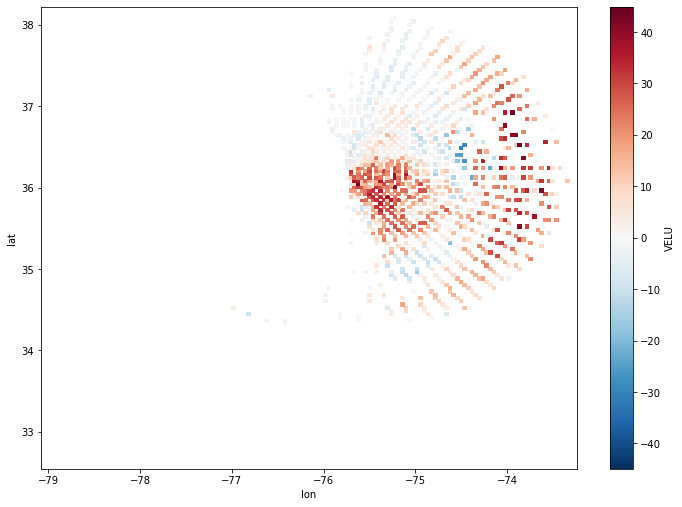

In [5]:
# Get indexes into the computed grid for each LOND and LATD defined in the data
duck_x_ind, duck_y_ind = gridded_index(xx, yy, duck_radial.data.LOND.values, duck_radial.data.LATD.values)

datas = {}
throw_away_columns = ['index', 'LOND', 'LATD']

for c in duck_radial.data.columns:
    e = np.ma.masked_all(shape=(lat.size, lon.size))
    e[duck_y_ind, duck_x_ind] = duck_radial.data[c].values
    datas[c] = e

duck_grid = xr.Dataset(
    { k: (['lat', 'lon'], v) for k, v in datas.items() if k not in throw_away_columns },
    coords={
        'lon': (['lon'], lon),
        'lat': (['lat'], lat),
    }
)
duck_grid.VELU.plot()

<module 'matplotlib.pyplot' from '/data/conda/miniconda3-py37/envs/dc2020/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 864x612 with 0 Axes>

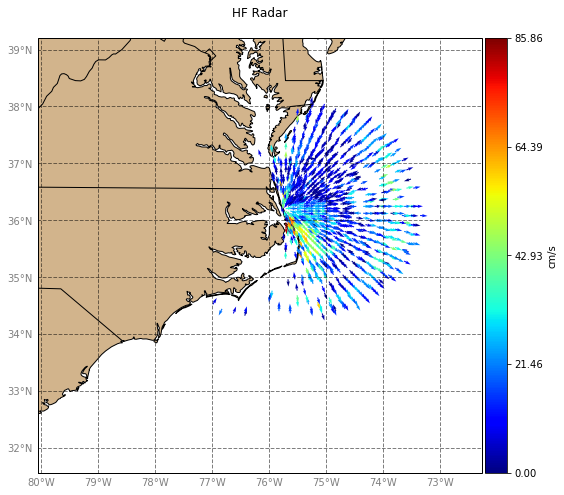

In [6]:
# Map the gridded DUCK data on the grid
plot_common(
    '',
    duck_grid['lon'],
    duck_grid['lat'],
    duck_grid.VELU,
    duck_grid.VELV,
    sub=1
)

# CORE - interpolate onto output grid

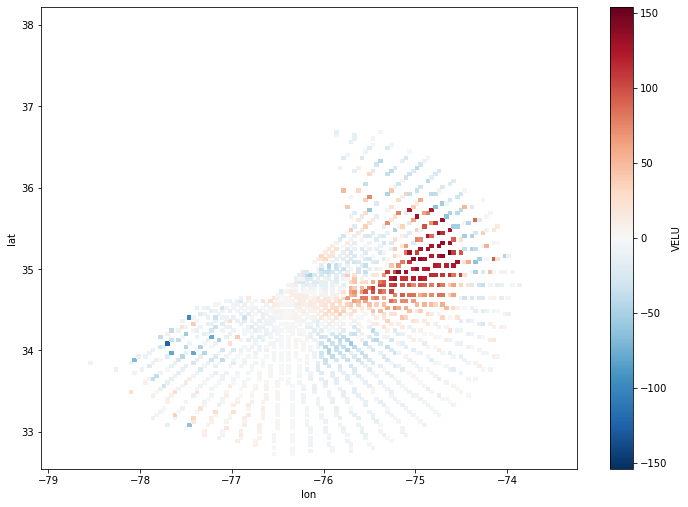

In [7]:
# Get indexes into the computed grid for each LOND and LATD defined in the data
core_x_ind, core_y_ind = gridded_index(xx, yy, core_radial.data.LOND.values, core_radial.data.LATD.values)

datas = {}
throw_away_columns = ['index', 'LOND', 'LATD']

for c in core_radial.data.columns:
    e = np.ma.masked_all(shape=(lat.size, lon.size))
    e[core_y_ind, core_x_ind] = core_radial.data[c].values
    datas[c] = e

core_grid = xr.Dataset(
    { k: (['lat', 'lon'], v) for k, v in datas.items() if k not in throw_away_columns },
    coords={
        'lon': (['lon'], lon),
        'lat': (['lat'], lat),
    }
)
core_grid.VELU.plot()

<module 'matplotlib.pyplot' from '/data/conda/miniconda3-py37/envs/dc2020/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 864x612 with 0 Axes>

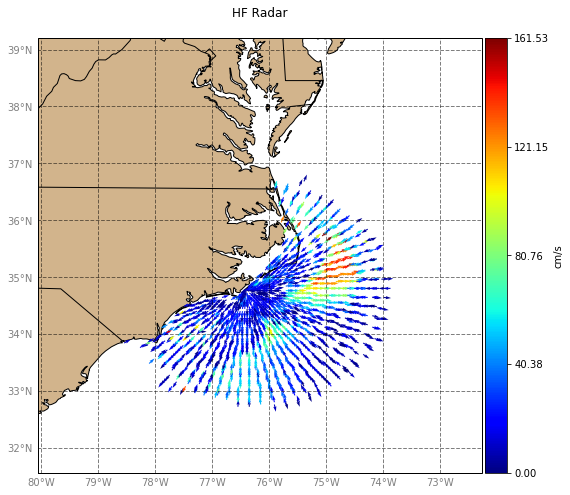

In [8]:
# Map the gridded CORE data on the grid
plot_common(
    '',
    core_grid['lon'],
    core_grid['lat'],
    core_grid.VELU,
    core_grid.VELV,
    sub=1
)

# Combine the data from both sites into a total vector product

In [9]:
# dumb, but it works
duck_vel = duck_grid['VELO'].values.flatten()
core_vel = core_grid['VELO'].values.flatten()

# CODAR uses temporal uncertainty in calculating totals
duck_std = duck_grid['ETMP'].values.flatten()
core_std = core_grid['ETMP'].values.flatten()

# heading needs to be changed from clockwise from N to counter-clockwise from x-axis
# - add 90 to start from same origin
# - change sign
duck_theta = np.mod(-1 * duck_grid['HEAD'].values.flatten() + 90, 360)
core_theta = np.mod(-1 * core_grid['HEAD'].values.flatten() + 90, 360)

U = np.ones_like(core_vel) * np.nan
V = np.ones_like(core_vel) * np.nan
nvalues = len(U)

In [10]:
vel_input = np.column_stack([duck_vel, core_vel])
std_input = np.column_stack([duck_std, core_std])
theta_input = np.column_stack([duck_theta, core_theta])

for i in range(nvalues):
    UV, VAR, n = rads2uv.rads2uv(
        vel_input[i],
        std_input[i],
        theta_input[i]
    )
    U[i] = UV[0]
    V[i] = UV[1]

U = U.reshape(duck_grid['VELO'].shape)
V = V.reshape(duck_grid['VELO'].shape)

<module 'matplotlib.pyplot' from '/data/conda/miniconda3-py37/envs/dc2020/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 864x612 with 0 Axes>

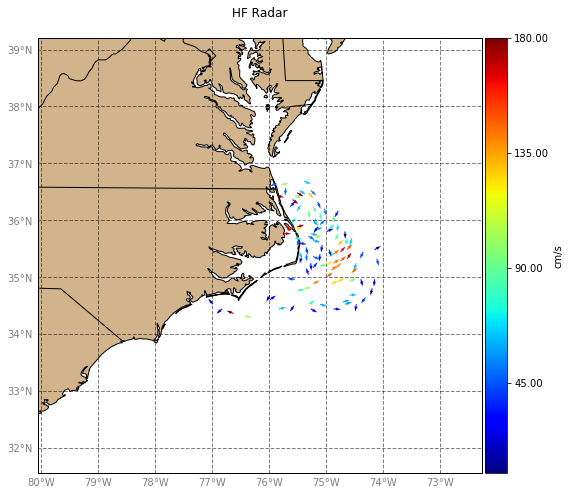

In [11]:
plot_common(
    '',
    duck_grid['lon'],
    duck_grid['lat'],
    U,
    V,
    sub=1,
    velocity_min=velocity_min,
    velocity_max=velocity_max
)

In [12]:
# Create a new xarray object with the vector data
nc_ds = xr.Dataset(
    {
        'time': datetime(2018, 1, 1, 0),
        'u': (['lat', 'lon'], U),
        'v': (['lat', 'lon'], V)
    },
    coords={
        'lon': lon,
        'lat': lat
    }
)
nc_ds.to_netcdf('output/UV.nc', mode='w', format='NETCDF4')
nc_ds

<xarray.Dataset>
Dimensions:  (lat: 142, lon: 146)
Coordinates:
  * lon      (lon) float64 -79.06 -79.02 -78.98 -78.94 ... -73.34 -73.3 -73.26
  * lat      (lat) float64 32.56 32.6 32.64 32.68 ... 38.08 38.12 38.16 38.2
Data variables:
    time     datetime64[ns] 2018-01-01
    u        (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    v        (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

<Figure size 864x612 with 0 Axes>

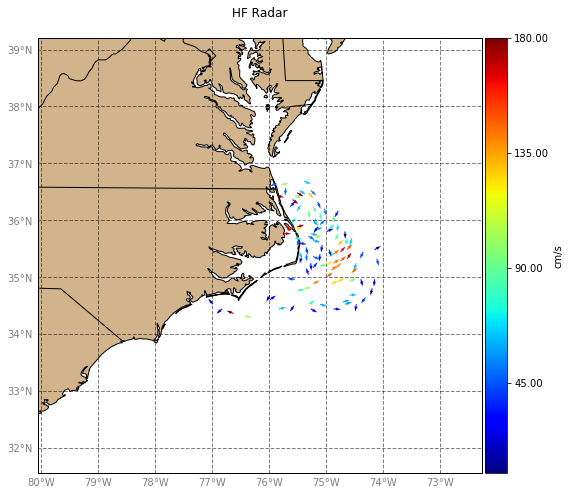

In [13]:
# Plot from the netCDF file
with xr.open_dataset('output/UV.nc') as xds:
    plot_common(
        '',
        xds.lon,
        xds.lat,
        xds.u,
        xds.v,
        sub=1,
        velocity_min=velocity_min,
        velocity_max=velocity_max,
    )